---

# CSCI 3202, Spring 2024
# Homework 5
# Due: Friday April 19, 2024 at 5:59 PM

<br> 

### Your name: Andrew Logue

<br> 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
import unittest

def whichbin(x, left_edges, dx):
    '''Function to return the bin number (starting from 0)
    that the water balloon is. arguments include `x`, the
    measured position of the balloon, and `left_edges`, an
    array of the x-coordinates of the left edges of the bins.
    Returns False if balloon is outside the domain.
    '''
    this_one = [k for k in range(len(left_edges)) if x >= left_edges[k] and x <= left_edges[k]+dx]
    return this_one[0] if this_one else False

---


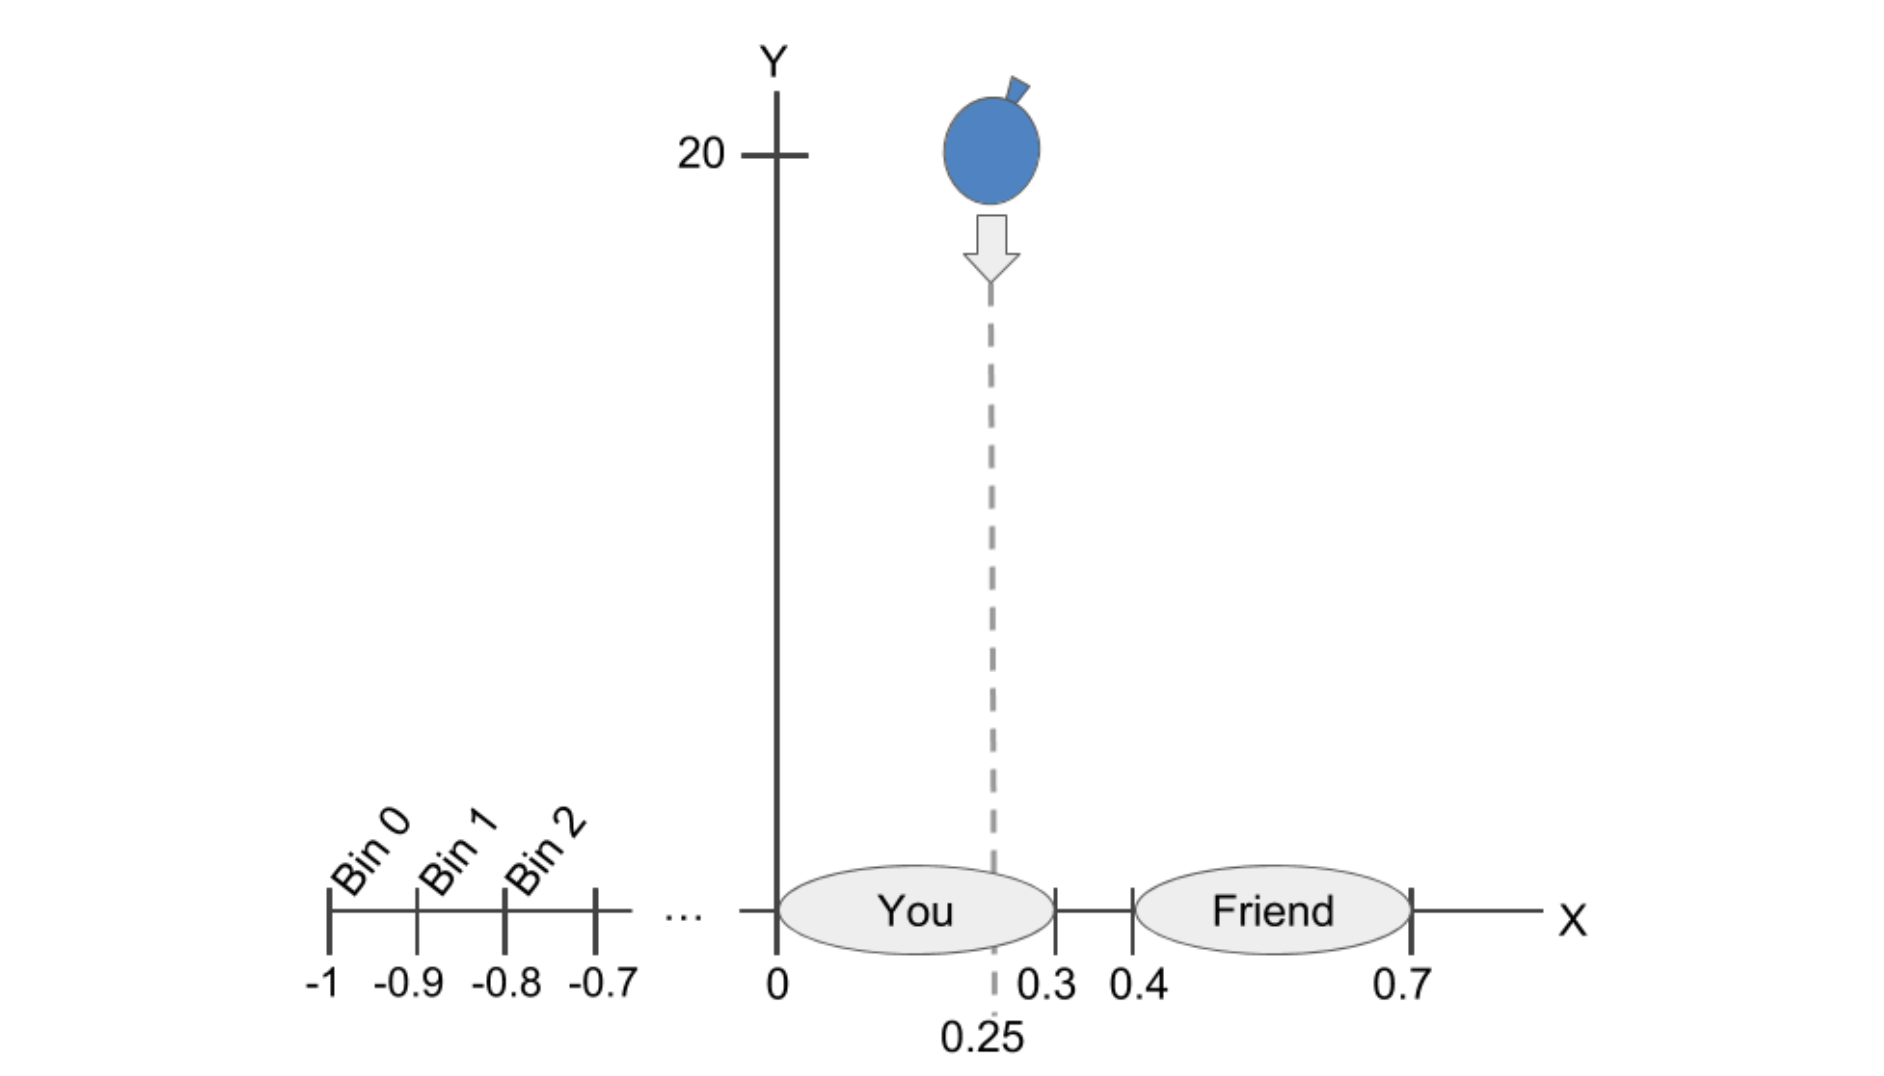

## Problem 1:  Water balloon tracking

Suppose you are walking down the street with your friend, when your sensors pick up a dangerous ***water balloon*** incoming! To track the water balloon and update your assessment of the probabilities that you or your friend will be hit, you think fast and implement a Hidden Markov Model. Unfortunately, you and your friend are also so busy implementing this model that you don't simply move out of the way (i.e., assume you are both stationary throughout this problem).

First, you discretize the environment by using bins in the x-direction of width $\Delta x = 0.1$ meters and time steps of 1/20 of a second. You do not need to consider any motion in the z-direction. The balloon starts 20 meters away in the y-direction at $(x_0, y_0)=(0.25,20)$, and is moving toward you at constant speed of $v = 2$ meters/second in the -y direction.

Since we are dealing with a discretized world, it might be easier to work with the actual **bin numbers** as opposed to decimal values for x.  And we can use the helper function `whichbin` to determine which bin numbers correspond to which raw x coordinate values. So let's keep track of $(\text{bin number}, y)$ tuple pairs as coordinates, where it should be clear from context whether we are referring to actual $x$ position or bin position.

Now, in addition to this constant movement towards you, the water balloon also experiences some random fluctuations in its $x$ coordinate along its path. If the balloon is in bin $i$ in time step $t$, then in time step $t+1$ the balloon is:
* still on course (in bin $i$) with probability $0.7$,
* in either of the adjacent bins ($i\pm 1$) with probability $0.1$, and
* in either of the bins 2 away ($i\pm 2$) with probability $0.05$.

Your torso occupies the region $0 \le x \le 0.3$, and your friend occupies the region $0.4 \le x \le 0.7$. So there are exactly 3 bins that correspond to hitting you, and 3 that correspond to hitting your friend. Assume that when the balloon reaches $y=0$, if it is within either of these $x$ regions, then it will hit you or your friend. 

Your sensors (i.e., perception) are fairly accurate, but there is some uncertainty in the x direction. When you measure the balloon's x-position, if the water balloon is actually in bin $i$, then:
* you get it exactly correct 5/17 of the time,
* you measure bins $i\pm 1$ each with probability 3/17,
* you measure bins $i\pm 2$ each with probability 2/17, and
* you measure bins $i\pm 3$ each with probability 1/17.

<br>


### (1a) 

First let's set up the discretized environment.

In [2]:
v = 2                        # speed of the water balloon
dt = 1/20                    # time step (seconds)
dx = 0.1                     # bin width along x
xb = np.arange(-1, 1.5, dx)  # x-coordinates of left-edges of bins
n_bins = len(xb)             # total number of bins
initial_location = (whichbin(0.25, xb, dx), 20)  # initial (bin, y) location of balloon
print(n_bins)
print(initial_location)

25
(12, 20)


Which bin numbers would the balloon need to be in in order to hit you at $y=0$?  What about your friend?  Store this information in some kind of variable - you may need to use it later.

Given the time step, speed in the y-direction, and initial distance of the water balloon, how many time steps, $T$, are there until the balloon reaches $y=0$?

In [3]:
me_bins = [whichbin(i, xb, dx) for i in np.arange(0, 0.31, dx)]
friend_bins = [whichbin(i, xb, dx) for i in np.arange(0.4, 0.71, dx)]

T = int((20/2)*20)

print(me_bins)
print(T)

[10, 11, 12, 13]
200


### (1b)

Set up a `Balloon` class.  Include attributes for:
* balloon speed
* the probabilities associated with changes in the balloon's x-position (by bin) from one time step to the next (i.e., the Markov transition probabilities)
* the current balloon location
* the time step for the simulation

and methods for:
* updating the x- and y-positions of the balloon between time steps. The x-position that you track should be the bin.
* declaring (through Boolean output) whether or not the balloon has arrived at $y=0$. This one might require you to carefully account for any floating point operations that lead to a non-integer y-position being compared against the integer 0.

In [4]:
class Balloon:    
    def __init__(self, v, markov_transition_probs, initial_location, dt):
        self.velocity = v # m/s
        self.markov_transition_probs = markov_transition_probs
        self.location = initial_location
        self.dt = dt
        
    def update_position(self):
        x_change = np.random.choice(list(self.markov_transition_probs.keys()), p=list(self.markov_transition_probs.values()))
        x_bin = self.location[0] + x_change
        self.location = (x_bin, self.location[1] - (self.velocity * self.dt))
    
    def splat(self):
        return self.location[1] <= 0
    

### (1c)

Set up a `Sensor` class to represent your ability to measure the balloon's position. Include an attribute for the sensor model probabilities, as well as a method `measure`, to return the measured $(x,y)$ pair as a tuple. The x-coordinate, however, should be the bin that you perceived the balloon to be in.

In [5]:
class Sensor:
    def __init__(self, sensor_probs):
        self.sensor_probs = sensor_probs

    def measure(self, position):
        error = np.random.choice(list(self.sensor_probs.keys()), p=list(self.sensor_probs.values()))
        # print(error)
        measured_x_bin = position[0] + error
        return (measured_x_bin, position[1])

### (1d)

Generate a simulated Markov chain sequence of water balloon states (bins along x-direction, $X$) and your corresponding measurements of those states ($E$). Make a plot of these two time series on the same axes, and be sure to include axis labels and a legend. 

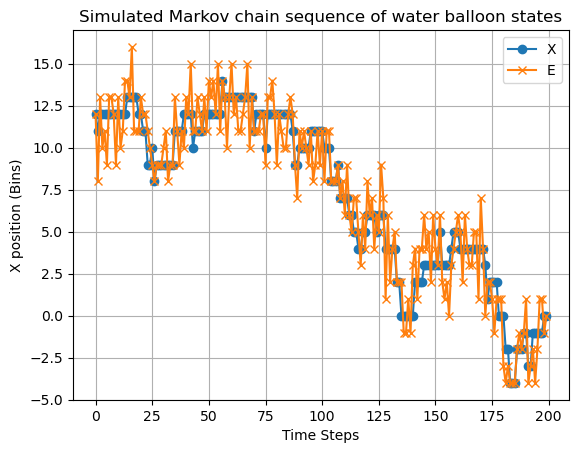

In [6]:
markov_transition_probs = {0: 0.7, 1: 0.1, -1: 0.1, 2: 0.05, -2: 0.05}
sensor_probs = {0: 5/17, 1: 3/17, -1: 3/17, 2: 2/17, -2: 2/17, 3: 1/17, -3: 1/17}

balloon = Balloon(v, markov_transition_probs, initial_location, dt)
sensor = Sensor(sensor_probs)

X = []
E = []
current_location = initial_location

for _ in range(T):
    X.append(current_location[0])
    E.append(sensor.measure(current_location)[0])
    balloon.update_position()
    current_location = balloon.location

# Plot
plt.plot(X, label='X', marker='o')
plt.plot(E, label='E', marker='x')
plt.xlabel('Time Steps')
plt.ylabel('X position (Bins)')
plt.title('Simulated Markov chain sequence of water balloon states')
plt.legend()
plt.grid(True)
plt.show()

### (1e)

Recall that `Forward` filtering updates our estimate of the probability distribution for $X_t$ in light of *all* of the evidence up to time $t$, $E_{1:t}$, as

$$f_{1:t} = \alpha ~ \texttt{forward}(f_{1:t-1}, E_t)$$
 
and the `Backward` function is a necessary step to update our estimate of the probability distribution for $X_k$ (some $k$ in $[0,t]$) in light of *all* of the evidence that occurred after $k$, $E_{k+1:t}$, as:

$$b_{k+1:t} = \texttt{backward}(b_{k+2:t}, E_{k+1})$$

where the specific functional forms of these recurrences is given in the textbook and lecture slides.

Code up `forward` and `backward` functions, taking in as arguments:
* `f1` or `b1`, the relevant previous (forward) or future (backward) "probability distribution" from the last recursive function call, respectively,
* `evidence`, which is the single observation that you are assimilating,
* `sens`, a `Sensor` object,
* `ball`, a `Balloon` object, and
* `xb`, some way to denote where the bins or x-coordinates are (which is more convenient may depend on how you stored your sensor and Markov transition probabilities).

Note that `forward` should return *all* of the probability distributions, at each time step, because you will need these for `backward`, which should return a single probability distribution.

In [7]:
def forward(f1, evidence, sens, ball, xb):
    n_bins = len(xb)
    x_bins = list(range(n_bins))
    f = [0] * n_bins
    for i in range(n_bins):
        x_new = x_bins[i]
        if evidence-x_new in sens.sensor_probs.keys(): 
            p_e_given_x = sens.sensor_probs[evidence - x_new]
        else:
            p_e_given_x = 0
        p_sum = 0
        for j in range(n_bins):
            x_old = x_bins[j]
            if x_new - x_old in ball.markov_transition_probs.keys():
                p_xnew_given_xold = ball.markov_transition_probs[x_new - x_old]
            else:
                p_xnew_given_xold = 0
            p_sum += p_xnew_given_xold * f1[j]
        f[i] = p_e_given_x * p_sum
    f = [p/sum(f) for p in f]
    return f

def backward(b1, evidence, sens, ball, xb):
    n_bins = len(xb)
    x_bins = list(range(n_bins))
    b = [0] * n_bins
    for i in range(n_bins):
        x_old = x_bins[i]
        p_sum = 0
        for j in range(n_bins):
            x_new = x_bins[j]
            if evidence-x_new in sens.sensor_probs.keys(): 
                p_e_given_x = sens.sensor_probs[evidence - x_new]
            else:
                p_e_given_x = 0
            if x_new - x_old in ball.markov_transition_probs.keys():
                p_xnew_given_x = ball.markov_transition_probs[x_new - x_old]
            else:
                p_xnew_given_xold = 0
            p_sum += p_e_given_x * b1[j] * p_xnew_given_x
        b[i] = p_sum
    return b

### (1f)

**For the remainder of this problem**, use the data set [data_waterballoon.csv]. The first column ($X$) corresponds to the actual bin number in which the water balloon is located during the time step corresponding to that row in the data table, and the second column ($E$) is the associated measurement. Note that there is no measurement associated with the initial location. You should use a uniform prior distribution for the initial location, over the actual location and one bin to either side.

Use your `forward` and `backward` functions to implement the forward-backward algorithm to obtain both filtered estimates and smoothed estimates of the probability distribution for water balloon location for all times after the initial time step.

In [8]:
df_waterballoon = pd.read_csv("data_waterballoon.csv")
X = df_waterballoon['X'].tolist()
E = df_waterballoon['E'].tolist()
E[0] = None

prior = np.zeros(n_bins)
prior[initial_location[0]] = 1/3
prior[initial_location[0] - 1] = 1/3
prior[initial_location[0] + 1] = 1/3

t = int(initial_location[1]/(v*dt))
fv = np.zeros((t+1, n_bins))
sv = np.zeros((t+1, n_bins))
fv[0] = prior
b = [1]*n_bins

for k in range(1, t+1):
    fv[k] = forward(fv[k-1], E[k], sensor, balloon, xb)
    
for k in range(t, 0, -1):
    product = np.multiply(fv[k], b)
    sum_product = sum(product)
    if sum_product != 0:
        sv[k] = [p / sum_product for p in product]
    b = backward(b, E[k], sensor, balloon, xb)

How does the filtered estimate at $t=1$ (first time step, not 1 second) differ from what you would estimate based only on the Markov model, without knowledge of $E_1$, your first measurement of balloon position?  To solve for the Markov model probability distribution $P(X_1)$, you can either use enumeration or calculate the probabilities by hand. (By hand isn't too bad, because there is nice symmetry you can take advantage of, so you only need to actually calculate a few things.)

Plot the two probability distributions on the same set of axes and comment on the differences. Be sure to include appropriate axis labels and a legend.

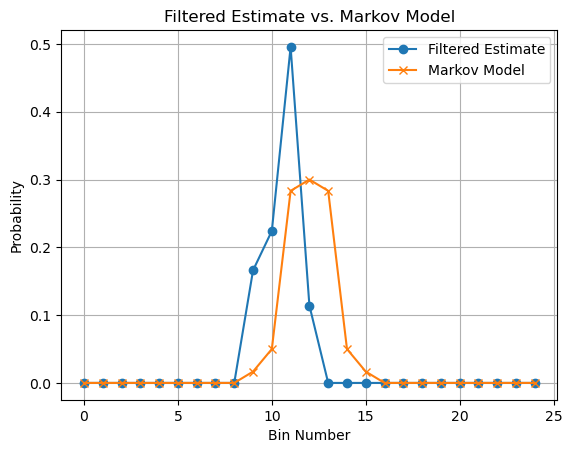

In [9]:
p1 = [0]*n_bins
p1[initial_location[0] - 3] = 0.0167
p1[initial_location[0] - 2] = 0.05
p1[initial_location[0] - 1] = 0.2833
p1[initial_location[0] + 0] = 0.3
p1[initial_location[0] + 1] = 0.2833
p1[initial_location[0] + 2] = 0.05
p1[initial_location[0] + 3] = 0.0167

# Plot
plt.plot(sv[1], label='Filtered Estimate', marker='o')
plt.plot(p1 , label='Markov Model', marker='x')
plt.xlabel('Bin Number')
plt.ylabel('Probability')
plt.title('Filtered Estimate vs. Markov Model')
plt.legend()
plt.grid(True)
plt.show()

### (1g)

Based on the smoothed estimates for the probability distribution of the water balloon at the moment the balloon reaches $y=0$, calculate the following:
* the probability that the balloon hits you,
* the probability that the balloon hits your friend, and
* the probability that the balloon misses both of you.

In [10]:
hit_me = sum([sv[t][b] for b in me_bins])
hit_friend = sum([sv[t][b] for b in friend_bins])
miss_both = 1- (hit_me + hit_friend)

print("The probability that the balloon hits you:", hit_me)
print("The probability that the balloon hits your friend:", hit_friend)
print("The probability that the balloon misses both of you:", miss_both)

The probability that the balloon hits you: 0.6717621827519407
The probability that the balloon hits your friend: 0.0
The probability that the balloon misses both of you: 0.32823781724805934


### (1h)

Make a plot of the smoothed estimates of the probability that the balloon will hit you, as a function of time step, and of the probability that the balloon will hit your friend. Include axis labels and a legend.  Write a few sentences commenting on the plot.

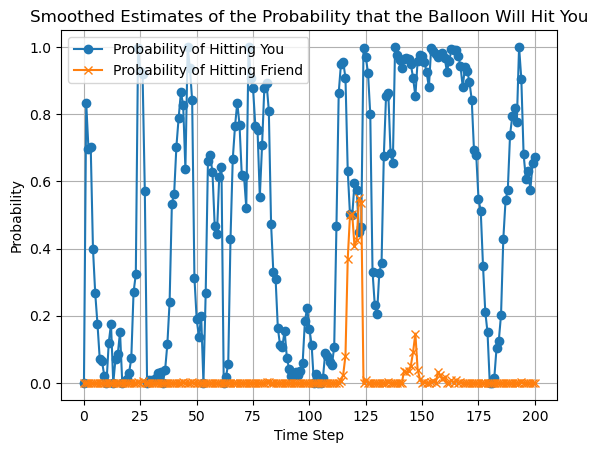

In [11]:
# Calculate the smoothed estimates of hitting you and hitting your friend over time steps
hit_me = [sum([sv[t][b] for b in me_bins]) for t in range(t+1)]
hit_friend = [sum([sv[t][b] for b in friend_bins]) for t in range(t+1)]

# Plot
plt.plot(hit_me, label='Probability of Hitting You', marker='o')
plt.plot(hit_friend , label='Probability of Hitting Friend', marker='x')
plt.xlabel('Time Step')
plt.ylabel('Probability')
plt.title('Smoothed Estimates of the Probability that the Balloon Will Hit You')
plt.legend()
plt.grid(True)
plt.show()

After analyzing the graph, it is clear that because the balloon is initially above your head, the probability that it falls on you is constantly high. The probability that it fall son your friend is overall lower across time, except for when the balloon drifts over into their bin space. This is what I expect to see. If the balloon's initial position was in between you and your friend, I would expect that the probability of it hitting either you or your friend would be much more equal across the time steps.

### (1i)

Give an example of an improvement we could make to the sensor model so that it would better represent the perception of a typical human being. Your answer should include both a revision of the code snippet below, as well as a few sentences justifying your code modifications. Note that you do **not** need to run this code; ***Pythonic*** pseudocode is fine.

```
class Sensor:    
    def measure(self, balloon):
        # calculate x error
        x_error = np.random.normal(0, self.std_x_error)
        x_meas = position[0] + x_error
        
        # calculate y error
        y_error = np.random.normal(0, self.std_y_error)
        y_meas = position[0] + y_error
    
        return (x_meas, y_meas)
```

An improvement we could make to the sensor model so that it would better respresent the perception of a typical human being is replacing the linear error probabilities with a more random error. I decided to introduce Gaussian noise to the model, using np.random.normal with a mean of 0, and a standard deviation of whatever is initialized. I applied this to both the x and y measurements, since the human eye would have error in both axis.

<br>

---


## Problem 2: your very own MDP

For this problem, you do not need to write any code, but rather communicate your ideas clearly using complete sentences and descriptions of the concepts the questions ask about. You can, of course, include some pseudocode if it helps, but that is not strictly necessary.


### (2a)

Describe something you think would be interesting to model using a Markov decision process.  Be **creative** - do not use any examples from your homework, class, or the textbook, and if you are working with other students, please **come up with your own example**. There are so, SO many possible answers!

Thinking back to my spring break trip, I would like to model finding the ideal lounge chair on a beach using a MDP.


### (2b)

What are the states associated with your MDP?

There are five states associated with my MDP:
- Not in a chair
- In a chair with shade
- In a chair with no shade
- In a chair too close to a loud family with shade
- In a chair too close to a loud family with no shade

### (2c)

What is the reward structure associated with your MDP?  Include a discussion of terminal/non-terminal states.

The most desirable state is being in a chair with shade, but a chair with no shade is fine. I do not want to be in a chair too close to a loud family, and definetly don't want to have a chair at all.

The terminal state would be being in a chair with shade, or being in a chair with no shade if X amount of chairs have been visited, or if the sun has set.

Non-terminal states would be not being in a chair, or being in a chair too close to a loud family.

### (2d)

What are the actions and transition model associated with your MDP?

The only three actions available are:
- Staying in the chair
- Moving from the chair (or spot on the beach if you're not in a chair).
- Destroying the loud family's sand castle, forcing them to move away

The transition model gives the probability that moving from an empty spot on the beach with no chair, or from a chair next to a loud family to a chair with no shade is high, and to a chair with shade is low. The the probability of moving from a chair with no shade to a chair with shade is low, but the probability of moving to any other state is high.

### (2e)

Interpret what an optimal policy represents in the context of your particular MDP.

In the context of my MDP, an optimal policy represents finding a chair with shade quickly. As the time spent searching increases, the model would begin to consider taking a chair with no shade, and eventually even a chair next to a loud family. The model would try to balance the finding a desirable chair with how long you've spent on the beach searching.